In [ ]:
import pandas as pd
df = pd.read_csv("Japan earthquakes 2001 - 2018.csv")

def convert_to_mw(mag,magType):
    if pd.isna(mag) or pd.isna(magType):
        return mag
    magType = magType.lower()
    
    if magType == 'mww':
        return mag
    elif magType == 'mwr':
        return mag + 0.1
    elif magType == 'mb':
        return (mag * 0.85) + 1.03
    else:
        return mag  

df['Magnitude'] = df.apply(lambda row: convert_to_mw(row['mag'], row['magType']), axis=1)


df['time'] = pd.to_datetime(df['time'])

df['Date'] = df['time'].dt.date  
df['Time'] = df['time'].dt.strftime('%H:%M:%S')  


df = df.drop(columns=['time'])

df = df.drop(columns=['mag', 'magType','nst','id','type','status','magSource','locationSource','net','updated'])

df.to_csv("cleaned_japan_earthquake_data.csv", index=False)
print(df.head())


   latitude  longitude  depth    gap   dmin   rms  \
0   48.3780   154.9620  35.00   92.0  5.044  0.63   
1   36.0733   139.7830  48.82  113.0  1.359  1.13   
2   38.8576   141.8384  50.56  145.0  1.286  0.84   
3   50.0727   156.1420  66.34  128.0  3.191  0.62   
4   33.9500   134.4942  38.19  104.0  0.558  0.61   

                                  place  horizontalError  depthError  \
0  269km SSW of Severo-Kuril'sk, Russia              7.6         1.7   
1               3km SSW of Sakai, Japan              6.0         6.1   
2            26km SSE of Ofunato, Japan              8.4         9.5   
3     67km S of Severo-Kuril'sk, Russia              9.7         7.8   
4         9km SW of Komatsushima, Japan              3.4        10.1   

   magError  magNst  Magnitude        Date      Time  
0     0.036   248.0      5.195  2018-11-27  14:34:20  
1     0.071    19.0      4.800  2018-11-26  23:33:50  
2     0.156    12.0      4.855  2018-11-26  13:04:02  
3     0.045   151.0      4.9

In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_japan_earthquake_data.csv")

numeric_cols = ['latitude', 'longitude', 'depth', 'Magnitude', 'gap', 'dmin', 'rms', 
                'horizontalError', 'depthError', 'magError', 'magNst']

df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.mean()))
df[numeric_cols] = df[numeric_cols].round(2)

df.to_csv("cleaned_japan_earthquake_data.csv", index=False)
print(df.head())


   latitude  longitude  depth    gap  dmin   rms  \
0     48.38     154.96  35.00   92.0  5.04  0.63   
1     36.07     139.78  48.82  113.0  1.36  1.13   
2     38.86     141.84  50.56  145.0  1.29  0.84   
3     50.07     156.14  66.34  128.0  3.19  0.62   
4     33.95     134.49  38.19  104.0  0.56  0.61   

                                  place  horizontalError  depthError  \
0  269km SSW of Severo-Kuril'sk, Russia              7.6         1.7   
1               3km SSW of Sakai, Japan              6.0         6.1   
2            26km SSE of Ofunato, Japan              8.4         9.5   
3     67km S of Severo-Kuril'sk, Russia              9.7         7.8   
4         9km SW of Komatsushima, Japan              3.4        10.1   

   magError  magNst  Magnitude        Date      Time  
0      0.04   248.0       5.20  2018-11-27  14:34:20  
1      0.07    19.0       4.80  2018-11-26  23:33:50  
2      0.16    12.0       4.86  2018-11-26  13:04:02  
3      0.04   151.0       4.94  20

In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_japan_earthquake_data.csv")

# Compute Seismic Parameters
df['Amplitude'] = 10 ** (df['Magnitude'] + 3)
df['Frequency'] = 10 ** (3 - df['Magnitude'])

df['Velocity'] = 3.5 * (10 ** (0.5 * df['Magnitude']))
df['Acceleration'] = df['Velocity'] * (2 * np.pi * df['Frequency'])
df['Seismic_Energy'] = 10 ** (1.5 * df['Magnitude'] + 4.8)
df['Seismic_Moment'] = 10 ** (1.5 * df['Magnitude'] + 9.1)


df[['Amplitude', 'Frequency', 'Velocity', 'Seismic_Energy', 'Seismic_Moment']] = \
df[['Amplitude', 'Frequency', 'Velocity', 'Seismic_Energy', 'Seismic_Moment']].round(2)

df.to_csv("cleaned_japan_earthquake_data.csv", index=False)

print(df.head())


   latitude  longitude  depth    gap  dmin   rms  \
0     48.38     154.96  35.00   92.0  5.04  0.63   
1     36.07     139.78  48.82  113.0  1.36  1.13   
2     38.86     141.84  50.56  145.0  1.29  0.84   
3     50.07     156.14  66.34  128.0  3.19  0.62   
4     33.95     134.49  38.19  104.0  0.56  0.61   

                                  place  horizontalError  depthError  \
0  269km SSW of Severo-Kuril'sk, Russia              7.6         1.7   
1               3km SSW of Sakai, Japan              6.0         6.1   
2            26km SSE of Ofunato, Japan              8.4         9.5   
3     67km S of Severo-Kuril'sk, Russia              9.7         7.8   
4         9km SW of Komatsushima, Japan              3.4        10.1   

   magError  ...  Magnitude        Date      Time     Amplitude  Frequency  \
0      0.04  ...       5.20  2018-11-27  14:34:20  1.584893e+08       0.01   
1      0.07  ...       4.80  2018-11-26  23:33:50  6.309573e+07       0.02   
2      0.16  ...    

In [ ]:
import pandas as pd
import numpy as np
from filterpy.kalman import KalmanFilter

df = pd.read_csv("cleaned_japan_earthquake_data.csv")
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)  
    kf.x = np.array([[data[0]], [0]])  
    kf.F = np.array([[1, 1], [0, 1]])
    kf.H = np.array([[1, 0]])
    kf.P *= 1000
    kf.R = 5  
    kf.Q = np.array([[0.01, 0.01], [0.01, 0.1]])

    filtered_data = []
    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0, 0])

    return np.round(filtered_data, 2)

# Apply Kalman Filter on Seismic Columns
df['Magnitude_Denoised'] = apply_kalman_filter(df['Magnitude'].values)
df['Amplitude_Denoised'] = apply_kalman_filter(df['Amplitude'].values)
df['Velocity_Denoised'] = apply_kalman_filter(df['Velocity'].values)

print(df[['Magnitude', 'Magnitude_Denoised', 'Amplitude', 'Amplitude_Denoised', 'Velocity', 'Velocity_Denoised']].head(5))


Number of earthquakes with denoised magnitude above 9: 14092
   Magnitude  Magnitude_Denoised     Amplitude  Amplitude_Denoised  Velocity  \
0       5.20                5.20  1.584893e+08        1.584893e+08   1393.38   
1       4.80                4.80  6.309573e+07        6.401951e+07    879.16   
2       4.86                4.78  7.244360e+07        5.523570e+07    942.04   
3       4.94                4.84  8.709636e+07        6.482282e+07   1032.92   
4       4.94                4.87  8.709636e+07        7.045154e+07   1032.92   

   Velocity_Denoised  
0            1393.38  
1             884.14  
2             847.16  
3             910.52  
4             945.66  


In [ ]:
import pandas as pd


df = pd.read_csv("cleaned_japan_earthquake_data.csv")
def assign_risk_zone(magnitude):
    if magnitude < 5:
        return "Low"
    elif 5 <= magnitude < 6.0:
        return "Medium"
    else:
        return "High"

df['Risk_Zone'] = df['Magnitude'].apply(assign_risk_zone)

risk_counts = df['Risk_Zone'].value_counts()

risk_details = df[['place', 'Magnitude', 'Risk_Zone']]

print("Earthquake Counts by Risk Zone:\n", risk_counts)
print("\nEarthquake Locations with Magnitude and Risk Zone:\n", risk_details.head())

df.to_csv("cleaned_japan_earthquake_data.csv", index=False)

print(df[['Magnitude', 'Risk_Zone']].head())


Earthquake Counts by Risk Zone:
 Risk_Zone
Medium    7410
Low       6365
High       317
Name: count, dtype: int64

Earthquake Locations with Magnitude and Risk Zone:
                                   place  Magnitude Risk_Zone
0  269km SSW of Severo-Kuril'sk, Russia       5.20    Medium
1               3km SSW of Sakai, Japan       4.80       Low
2            26km SSE of Ofunato, Japan       4.86       Low
3     67km S of Severo-Kuril'sk, Russia       4.94       Low
4         9km SW of Komatsushima, Japan       4.94       Low
   Magnitude Risk_Zone
0       5.20    Medium
1       4.80       Low
2       4.86       Low
3       4.94       Low
4       4.94       Low


Anomaly Count:
 Anomaly
Normal     13387
Anomaly      705
Name: count, dtype: int64


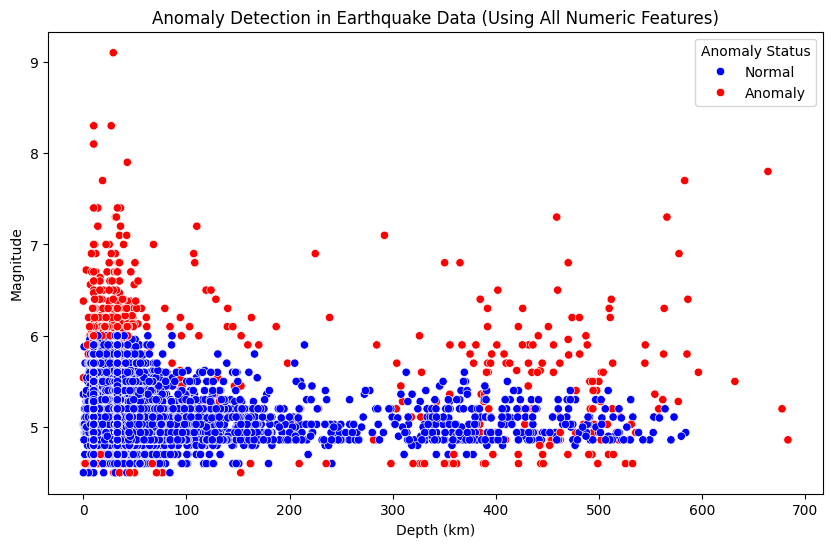

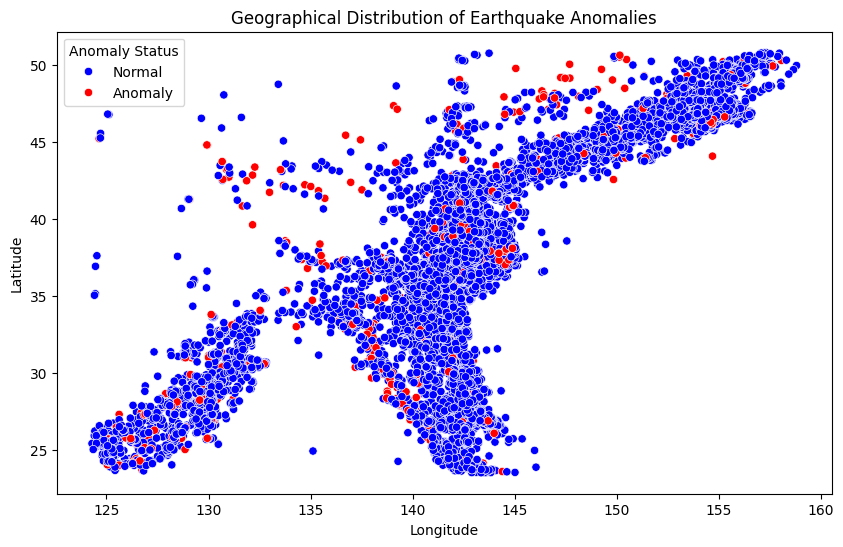

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


df = pd.read_csv("cleaned_japan_earthquake_data.csv")

numeric_cols = df.select_dtypes(include=['number']).columns
X = df[numeric_cols]

#Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X)


df['Anomaly'] = df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

anomaly_count = df['Anomaly'].value_counts()
print("Anomaly Count:\n", anomaly_count)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['depth'], y=df['Magnitude'], hue=df['Anomaly'], palette={'Normal': 'blue', 'Anomaly': 'red'})
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.title("Anomaly Detection in Earthquake Data (Using All Numeric Features)")
plt.legend(title="Anomaly Status")
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['Anomaly'], palette={'Normal': 'blue', 'Anomaly': 'red'})
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Earthquake Anomalies")
plt.legend(title="Anomaly Status")
plt.show()





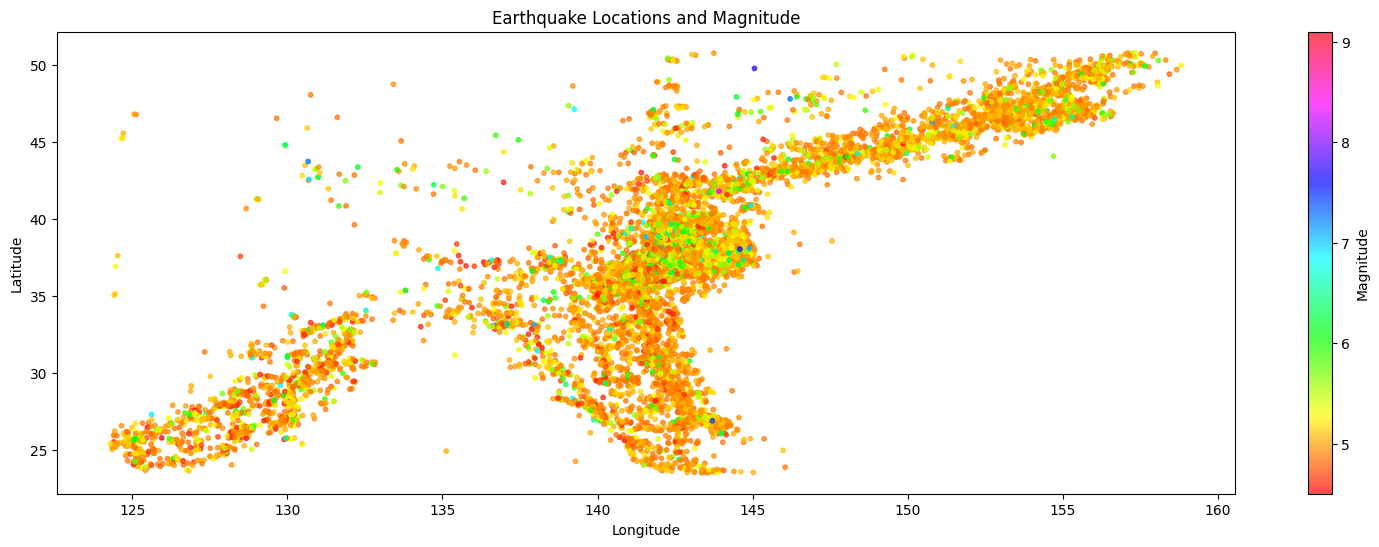

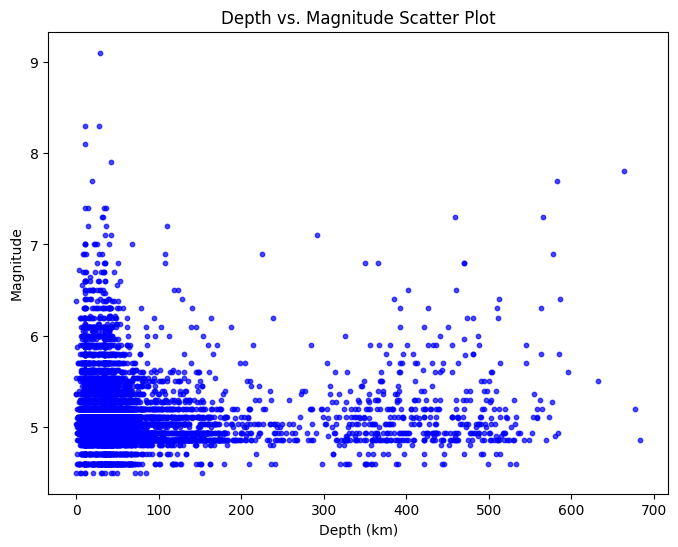

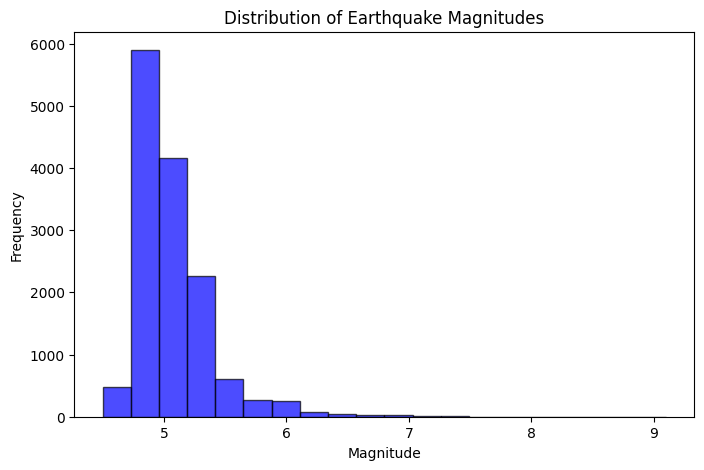

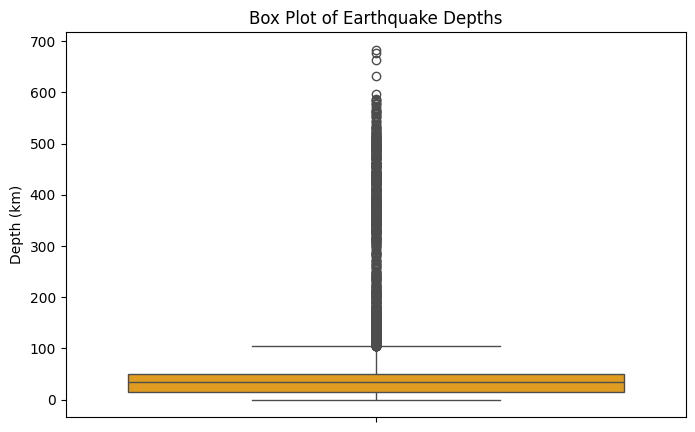

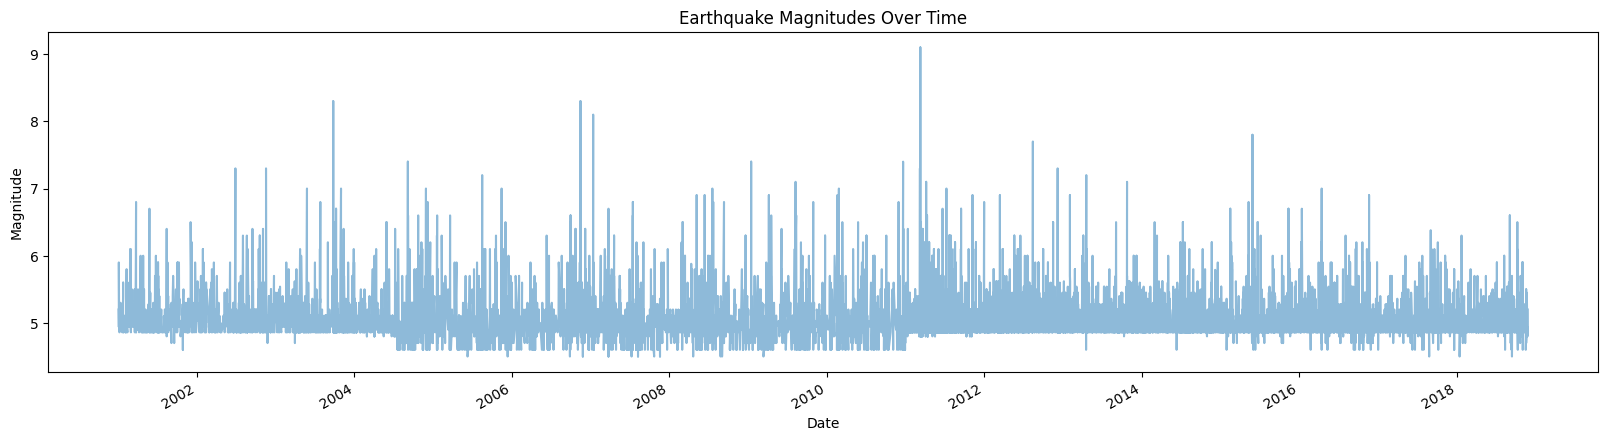

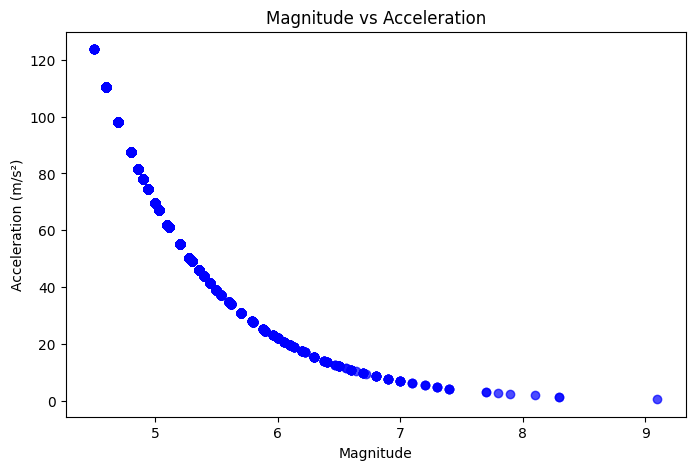

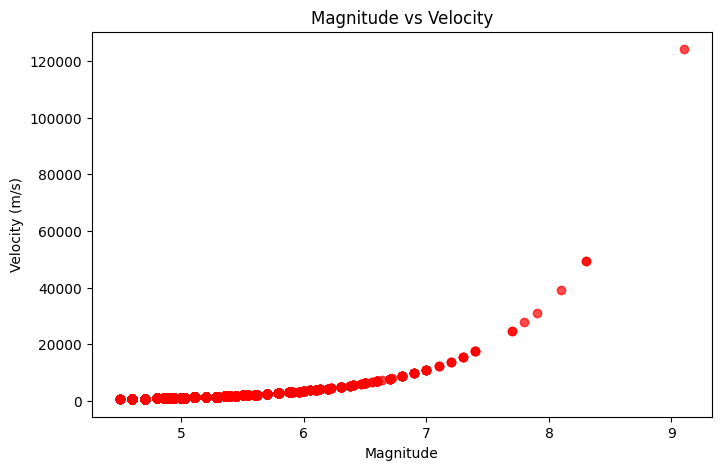

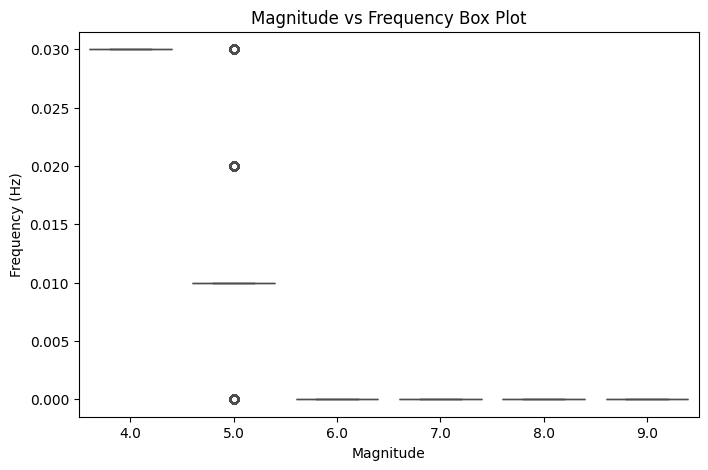

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(19, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['Magnitude'], s=10,cmap='hsv', alpha=0.7)
plt.colorbar(label="Magnitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Earthquake Locations and Magnitude")
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(df['depth'], df['Magnitude'],s=10, alpha=0.7,color='blue')
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.title("Depth vs. Magnitude Scatter Plot")
plt.show()



plt.figure(figsize=(8, 5))
plt.hist(df['Magnitude'], bins=20, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("Distribution of Earthquake Magnitudes")
plt.show()




plt.figure(figsize=(8, 5))
sns.boxplot(y=df['depth'], color="orange")
plt.title("Box Plot of Earthquake Depths")
plt.ylabel("Depth (km)")
plt.show()



plt.figure(figsize=(20, 5))
df['Magnitude'].plot(linestyle='-', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Magnitude")
plt.title("Earthquake Magnitudes Over Time")
plt.show()


plt.figure(figsize=(8, 5))
plt.scatter(df['Magnitude'], df['Acceleration'], alpha=0.7, color="blue")
plt.xlabel("Magnitude")
plt.ylabel("Acceleration (m/s²)")
plt.title("Magnitude vs Acceleration")
plt.show()

# PLOT: Magnitude vs Velocity
plt.figure(figsize=(8, 5))
plt.scatter(df['Magnitude'], df['Velocity'], alpha=0.7, color="red")
plt.xlabel("Magnitude")
plt.ylabel("Velocity (m/s)")
plt.title("Magnitude vs Velocity")
plt.show()

# PLOT: Magnitude vs Frequency
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Magnitude'].round(), y=df['Frequency'], color='red')
plt.xlabel("Magnitude")
plt.ylabel("Frequency (Hz)")
plt.title("Magnitude vs Frequency Box Plot")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from pyswarm import pso

df = pd.read_csv("cleaned_japan_earthquake_data.csv")

df['Risk_Zone_encoded'] = LabelEncoder().fit_transform(df['Risk_Zone'])

selected_columns = [
    'latitude', 'longitude', 'depth', 'gap', 'dmin', 'rms','Magnitude',
    'horizontalError', 'depthError', 'magError', 'magNst',
    'Amplitude', 'Frequency', 'Velocity',
    'Seismic_Energy', 'Seismic_Moment', 'Acceleration',
    'Risk_Zone_encoded'
]

numeric_features = df[selected_columns]
target = df['Magnitude']

mi_scores = mutual_info_regression(numeric_features, target)

def objective_function(feature_weights):
    selected = feature_weights > 0.5
    if not np.any(selected):
        return 1e6  
    score = np.mean(mi_scores[selected])
    return -score 

lb = [0] * len(numeric_features.columns)
ub = [1] * len(numeric_features.columns)

best_weights, _ = pso(objective_function, lb, ub, swarmsize=10, maxiter=10)

selected_feature_names = numeric_features.columns[np.array(best_weights) > 0.5]
print("Selected Features using PSO:", list(selected_feature_names))


Stopping search: maximum iterations reached --> 10
Selected Features using PSO: ['latitude', 'Magnitude', 'depthError', 'Amplitude', 'Velocity', 'Seismic_Energy', 'Seismic_Moment', 'Acceleration', 'Risk_Zone_encoded']


Stopping search: maximum iterations reached --> 10
Selected Features using PSO:
['Amplitude', 'Velocity', 'Seismic_Energy', 'Seismic_Moment', 'Risk_Zone_encoded']
Best Seismic Wave Path (ACO):
Amplitude → Seismic_Moment → Velocity → Seismic_Energy → Risk_Zone_encoded


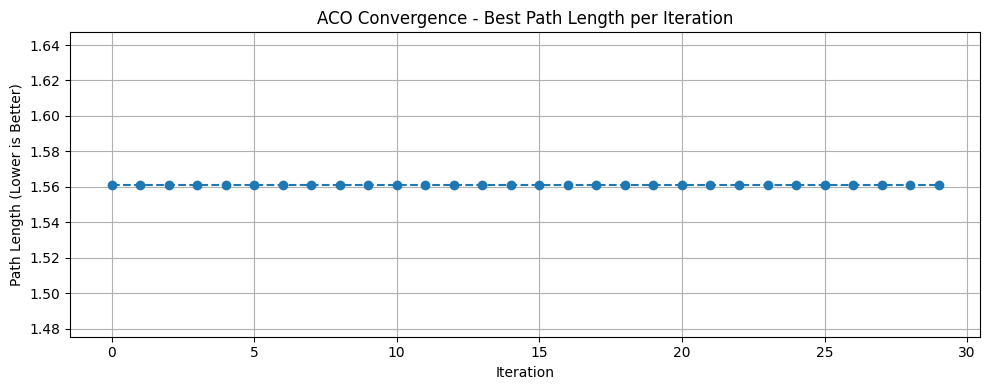

Stopping search: Swarm best objective change less than 1e-08

🔧 Optimized XGBoost Hyperparameters via PSO:
Learning Rate: 0.1821, Max Depth: 8, N Estimators: 247, Subsample: 0.93
📊 Final MAE on Validation Set: 0.0002


In [ ]:
import numpy as np
import pandas as pd
import random
import os

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from pyswarm import pso
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


df = pd.read_csv("cleaned_japan_earthquake_data.csv")
df['Risk_Zone_encoded'] = LabelEncoder().fit_transform(df['Risk_Zone'])

selected_columns_all = [
    'latitude', 'longitude', 'depth', 'gap', 'dmin', 'rms',
    'horizontalError', 'depthError', 'magError', 'magNst',
    'Amplitude', 'Frequency', 'Velocity',
    'Seismic_Energy', 'Seismic_Moment', 'Acceleration',
    'Risk_Zone_encoded'
]

numeric_features = df[selected_columns_all]
target = df['Magnitude']


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(numeric_features)
X_scaled = pd.DataFrame(X_scaled, columns=numeric_features.columns)

mi_scores = mutual_info_regression(X_scaled, target, random_state=SEED)

# PSO for feature selection
def objective_function(feature_weights):
    selected = feature_weights > 0.5
    if not np.any(selected):
        return 1e6
    score = np.mean(mi_scores[selected])
    return -score

lb = [0] * len(numeric_features.columns)
ub = [1] * len(numeric_features.columns)

best_weights, _ = pso(objective_function, lb, ub, swarmsize=10, maxiter=10)

selected_mask = np.array(best_weights) > 0.5
selected_feature_names = X_scaled.columns[selected_mask]
X_selected = X_scaled[selected_feature_names]

print("Selected Features using PSO:")
print(list(selected_feature_names))

# ACO for path optimization
corr = X_selected.corr().abs()
graph = 1 - corr.fillna(0).values
n_nodes = len(selected_feature_names)
n_ants = 10
n_iterations = 30
alpha = 1
beta = 2
rho = 0.1
pheromone = np.ones((n_nodes, n_nodes))

def choose_next(current, visited):
    prob = []
    for j in range(n_nodes):
        if j in visited or j == current:
            prob.append(0)
        else:
            tau = pheromone[current][j] ** alpha
            eta = (1.0 / graph[current][j]) ** beta if graph[current][j] > 0 else 0
            prob.append(tau * eta)
    total = sum(prob)
    if total == 0:
        return random.choice([j for j in range(n_nodes) if j not in visited])
    prob = [p / total for p in prob]
    return np.random.choice(range(n_nodes), p=prob)

best_path = None
best_length = float('inf')
all_lengths = []

for iteration in range(n_iterations):
    iteration_paths = []
    iteration_lengths = []

    for ant in range(n_ants):
        visited = [0]  # fixed starting node
        while len(visited) < n_nodes:
            next_node = choose_next(visited[-1], visited)
            visited.append(next_node)
        length = sum(graph[visited[i]][visited[i + 1]] for i in range(n_nodes - 1))
        iteration_paths.append(visited)
        iteration_lengths.append(length)

        if length < best_length:
            best_length = length
            best_path = visited

    all_lengths.append(min(iteration_lengths))

    pheromone *= (1 - rho)
    for path, length in zip(iteration_paths, iteration_lengths):
        for i in range(n_nodes - 1):
            pheromone[path[i]][path[i + 1]] += 1.0 / length

best_path_features = [selected_feature_names[i] for i in best_path]

print("Best Seismic Wave Path (ACO):")
print(" → ".join(best_path_features))

plt.figure(figsize=(10, 4))
plt.plot(all_lengths, marker='o', linestyle='--')
plt.title("ACO Convergence - Best Path Length per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Path Length (Lower is Better)")
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost training using ACO-ordered features
X_final = X_scaled[best_path_features]
y_final = target

X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.2, random_state=SEED)

def xgb_fitness(params):
    learning_rate, max_depth, n_estimators, subsample = params

    model = XGBRegressor(
        learning_rate=learning_rate,
        max_depth=int(round(max_depth)),
        n_estimators=int(round(n_estimators)),
        subsample=subsample,
        objective='reg:squarederror',
        random_state=SEED,
        verbosity=0
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae

# PSO for XGBoost hyperparameter tuning
lb = [0.01, 3, 50, 0.5]
ub = [0.3, 10, 300, 1.0]

best_params, _ = pso(xgb_fitness, lb, ub, swarmsize=10, maxiter=15)

lr, depth, estimators, subsample = best_params
optimized_model = XGBRegressor(
    learning_rate=lr,
    max_depth=int(round(depth)),
    n_estimators=int(round(estimators)),
    subsample=subsample,
    objective='reg:squarederror',
    random_state=SEED
)

optimized_model.fit(X_train, y_train)
final_preds = optimized_model.predict(X_val)
final_mae = mean_absolute_error(y_val, final_preds)

print("\n🔧 Optimized XGBoost Hyperparameters via PSO:")
print(f"Learning Rate: {lr:.4f}, Max Depth: {int(round(depth))}, N Estimators: {int(round(estimators))}, Subsample: {subsample:.2f}")
print(f"📊 Final MAE on Validation Set: {final_mae:.4f}")


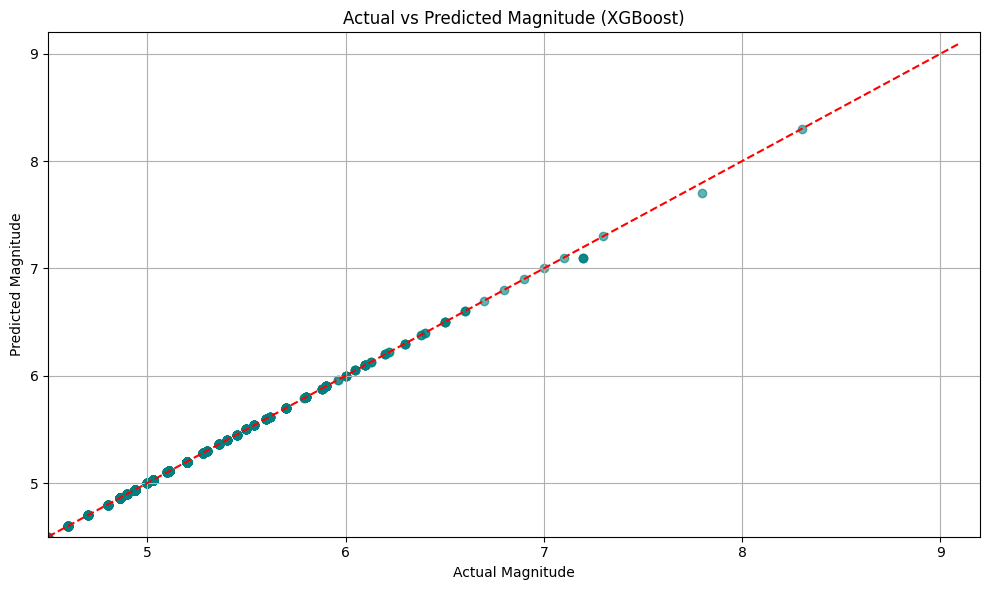

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, final_preds, color='teal', alpha=0.6)
plt.plot([4.5, 9.1], [4.5, 9.1], 'r--')
plt.xlim(4.5, 9.2)
plt.ylim(4.5, 9.2)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.title("Actual vs Predicted Magnitude (XGBoost)")
plt.grid(True)
plt.tight_layout()
plt.show()



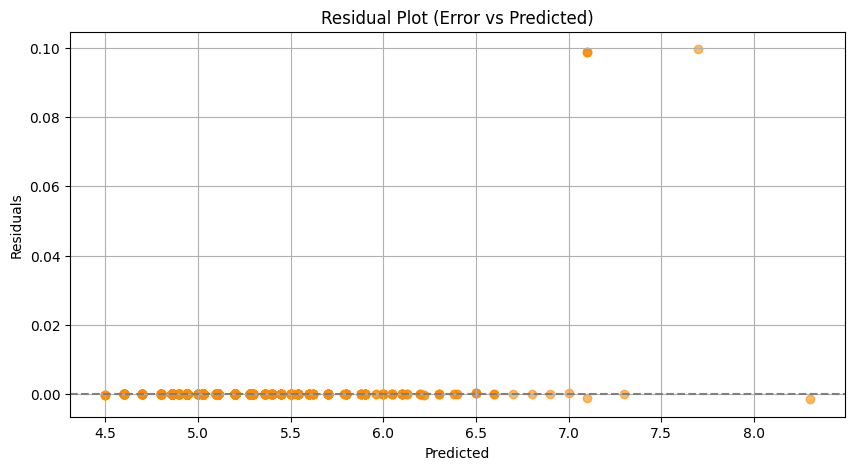

In [12]:
residuals = y_val - final_preds
plt.figure(figsize=(10, 5))
plt.scatter(final_preds, residuals, color='darkorange', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot (Error vs Predicted)")
plt.grid(True)
plt.show()


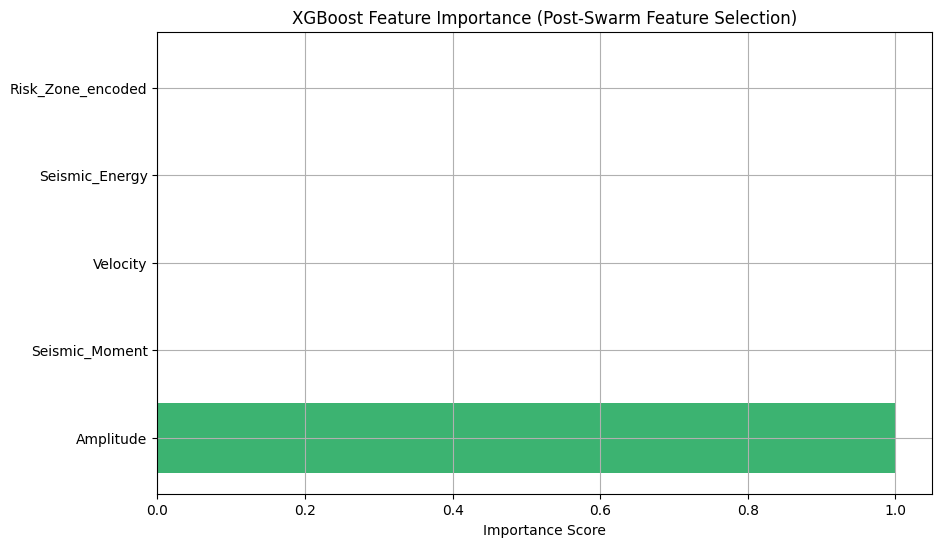

In [13]:
plt.figure(figsize=(10, 6))
importances = optimized_model.feature_importances_
features = X_final.columns
plt.barh(features, importances, color='mediumseagreen')
plt.title("XGBoost Feature Importance (Post-Swarm Feature Selection)")
plt.xlabel("Importance Score")
plt.grid(True)
plt.show()


Stopping search: maximum iterations reached --> 10
Stopping search: Swarm best objective change less than 1e-08
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

🎯 Final Evaluation
Total Reward: 2271.6
Actions Taken (0=No Alert, 1=Alert, 2=Wait): [array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(2), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(2), array(0), array(0)]...


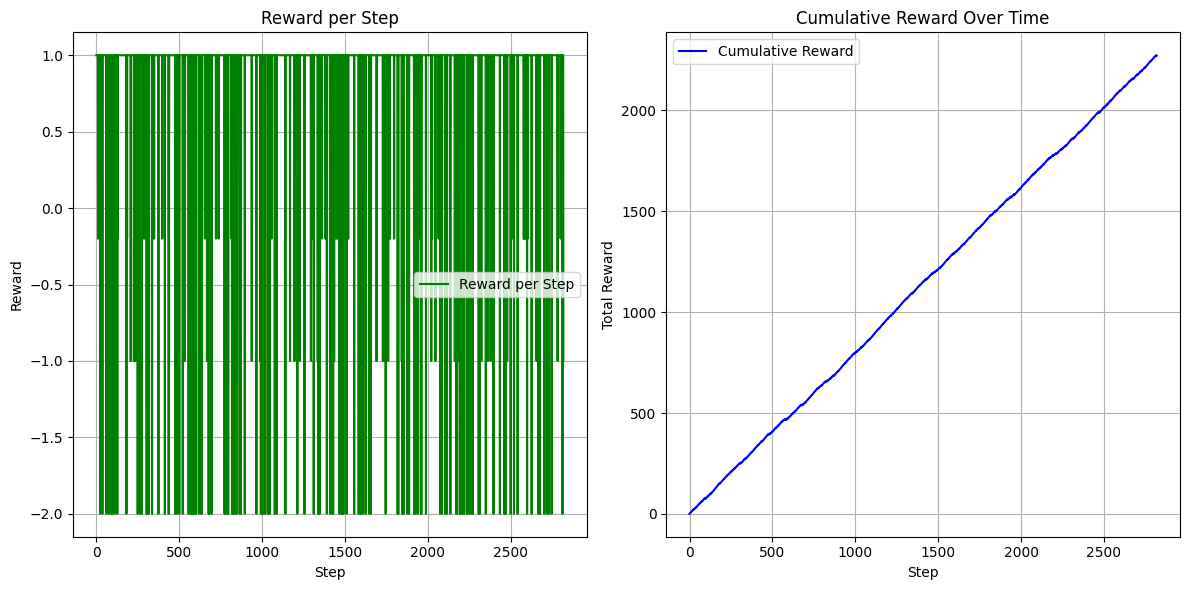

In [ ]:
# Seismic Prediction Pipeline with PSO, ACO, and RL
import numpy as np
import pandas as pd
import random
import os

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from pyswarm import pso
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Load data
df = pd.read_csv("cleaned_japan_earthquake_data.csv")
df['Risk_Zone_encoded'] = LabelEncoder().fit_transform(df['Risk_Zone'])

selected_columns_all = [
    'latitude', 'longitude', 'depth', 'gap', 'dmin', 'rms',
    'horizontalError', 'depthError', 'magError', 'magNst',
    'Amplitude', 'Frequency', 'Velocity',
    'Seismic_Energy', 'Seismic_Moment', 'Acceleration',
    'Risk_Zone_encoded'
]

numeric_features = df[selected_columns_all]
target = df['Magnitude']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(numeric_features)
X_scaled = pd.DataFrame(X_scaled, columns=numeric_features.columns)

mi_scores = mutual_info_regression(X_scaled, target, random_state=SEED)

# PSO Feature Selection
def objective_function(feature_weights):
    selected = feature_weights > 0.5
    if not np.any(selected):
        return 1e6
    score = np.mean(mi_scores[selected])
    return -score

lb = [0] * len(numeric_features.columns)
ub = [1] * len(numeric_features.columns)

best_weights, _ = pso(objective_function, lb, ub, swarmsize=10, maxiter=10)

selected_mask = np.array(best_weights) > 0.5
selected_feature_names = X_scaled.columns[selected_mask]
X_selected = X_scaled[selected_feature_names]

# ACO for path optimization
corr = X_selected.corr().abs()
graph = 1 - corr.fillna(0).values
n_nodes = len(selected_feature_names)
n_ants = 10
n_iterations = 30
alpha = 1
beta = 2
rho = 0.1
pheromone = np.ones((n_nodes, n_nodes))

def choose_next(current, visited):
    prob = []
    for j in range(n_nodes):
        if j in visited or j == current:
            prob.append(0)
        else:
            tau = pheromone[current][j] ** alpha
            eta = (1.0 / graph[current][j]) ** beta if graph[current][j] > 0 else 0
            prob.append(tau * eta)
    total = sum(prob)
    if total == 0:
        return random.choice([j for j in range(n_nodes) if j not in visited])
    prob = [p / total for p in prob]
    return np.random.choice(range(n_nodes), p=prob)

best_path = None
best_length = float('inf')

for iteration in range(n_iterations):
    iteration_paths = []
    iteration_lengths = []

    for ant in range(n_ants):
        visited = [0]
        while len(visited) < n_nodes:
            next_node = choose_next(visited[-1], visited)
            visited.append(next_node)
        length = sum(graph[visited[i]][visited[i + 1]] for i in range(n_nodes - 1))
        iteration_paths.append(visited)
        iteration_lengths.append(length)

        if length < best_length:
            best_length = length
            best_path = visited

    pheromone *= (1 - rho)
    for path, length in zip(iteration_paths, iteration_lengths):
        for i in range(n_nodes - 1):
            pheromone[path[i]][path[i + 1]] += 1.0 / length

best_path_features = [selected_feature_names[i] for i in best_path]

# XGBoost Model Optimization using PSO
X_final = X_scaled[best_path_features]
y_final = target

X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.2, random_state=SEED)

def xgb_fitness(params):
    learning_rate, max_depth, n_estimators, subsample = params
    model = XGBRegressor(
        learning_rate=learning_rate,
        max_depth=int(round(max_depth)),
        n_estimators=int(round(n_estimators)),
        subsample=subsample,
        objective='reg:squarederror',
        random_state=SEED,
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    return mae

lb = [0.01, 3, 50, 0.5]
ub = [0.3, 10, 300, 1.0]
best_params, _ = pso(xgb_fitness, lb, ub, swarmsize=10, maxiter=15)

lr, depth, estimators, subsample = best_params
optimized_model = XGBRegressor(
    learning_rate=lr,
    max_depth=int(round(depth)),
    n_estimators=int(round(estimators)),
    subsample=subsample,
    objective='reg:squarederror',
    random_state=SEED
)
optimized_model.fit(X_train, y_train)

class SeismicAlertEnv(gym.Env):
    def __init__(self, model, X_data, y_data, threshold=5.5):
        super(SeismicAlertEnv, self).__init__()
        self.model = model
        self.X = X_data.reset_index(drop=True)
        self.y = y_data.reset_index(drop=True)
        self.threshold = threshold
        self.current_index = 0

        self.action_space = spaces.Discrete(3)  # 0 = No Alert, 1 = Alert, 2 = Wait
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(X_data.shape[1],), dtype=np.float32
        )

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_index = 0
        obs = self.X.iloc[self.current_index].values.astype(np.float32)
        return obs, {}

    def step(self, action):
        obs = self.X.iloc[self.current_index].values.astype(np.float32)
        true_mag = self.y.iloc[self.current_index]
        pred_mag = self.model.predict(obs.reshape(1, -1))[0]

        reward = 0
        if action == 1:
            reward = 1 if pred_mag >= self.threshold else -1
        elif action == 0:
            reward = 1 if pred_mag < self.threshold else -2
        else:
            reward = -0.2

        self.current_index += 1
        done = self.current_index >= len(self.X)
        next_obs = (
            self.X.iloc[self.current_index].values.astype(np.float32)
            if not done
            else np.zeros_like(obs)
        )
        terminated = done
        truncated = False
        return next_obs, reward, terminated, truncated, {}

# Train RL Agent
env = SeismicAlertEnv(optimized_model, X_val, y_val)
check_env(env, warn=True)
agent = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-3, seed=SEED)
agent.learn(total_timesteps=5000)
agent.save("rl_seismic_alert_agent")


obs, _ = env.reset()
total_reward = 0
actions_taken = []
step_rewards = []
cumulative_rewards = []

while True:
    action, _states = agent.predict(obs)
    actions_taken.append(action)
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    step_rewards.append(reward)
    cumulative_rewards.append(total_reward)
    if done:
        break

print("\n🎯 Final Evaluation")
print(f"Total Reward: {total_reward}")
print(f"Actions Taken (0=No Alert, 1=Alert, 2=Wait): {actions_taken[:30]}...")

# Plot reward curve
plt.figure(figsize=(12, 6))

# Step-wise reward
plt.subplot(1, 2, 1)
plt.plot(step_rewards, label='Reward per Step', color='green')
plt.title('Reward per Step')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.grid(True)
plt.legend()

# Cumulative reward
plt.subplot(1, 2, 2)
plt.plot(cumulative_rewards, label='Cumulative Reward', color='blue')
plt.title('Cumulative Reward Over Time')
plt.xlabel('Step')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

        High       1.00      1.00      1.00        59
         Low       1.00      1.00      1.00      1307
      Medium       1.00      1.00      1.00      1453

    accuracy                           1.00      2819
   macro avg       1.00      1.00      1.00      2819
weighted avg       1.00      1.00      1.00      2819



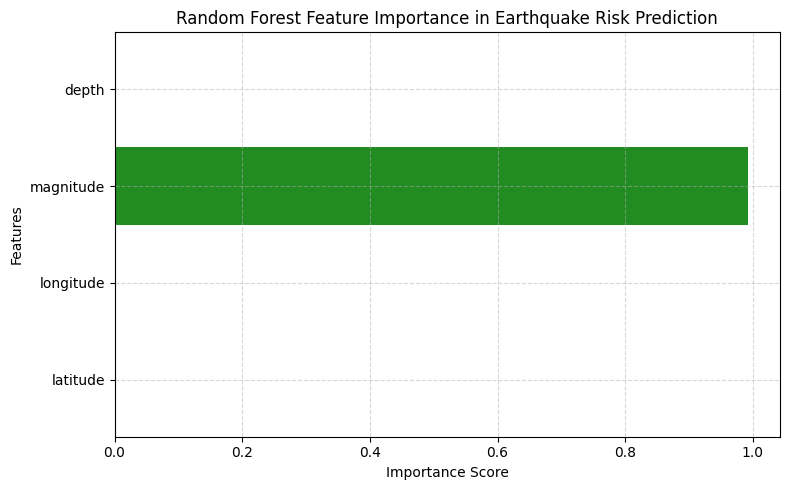

Predicted Risk Zone (Random Forest): ['High' 'Medium' 'High' 'High' 'Medium']


c:\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import plotly.express as px



df = pd.read_csv("cleaned_japan_earthquake_data.csv")

le = LabelEncoder()
df['Risk_Zone_encoded'] = LabelEncoder().fit_transform(df['Risk_Zone'])

features = df[['latitude', 'longitude', 'Magnitude', 'depth']]  
labels = df['Risk_Zone_encoded']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

le = LabelEncoder()
le.fit(df['Risk_Zone'])

print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = ['latitude', 'longitude', 'magnitude', 'depth']  
# Plot
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='forestgreen')
plt.title("Random Forest Feature Importance in Earthquake Risk Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



# New input data: [latitude, longitude, magnitude, depth]
new_data = [
    [30.5, 78.2, 6.4, 10.0],
    [32.1, 75.6, 5.8, 20.0],
    [28.9, 77.2, 6.0, 15.0],
    [31.7, 76.8, 6.2, 12.0],
    [29.3, 79.5, 5.5, 18.0]
]


new_data_scaled = scaler.transform(new_data)


predicted_zones = rf.predict(new_data_scaled)


predicted_zone_labels = le.inverse_transform(predicted_zones)

print(f"Predicted Risk Zone (Random Forest): {predicted_zone_labels}")



df_new = pd.DataFrame(new_data, columns=['latitude', 'longitude', 'magnitude', 'depth'])
df_new['predicted_zone'] = predicted_zone_labels

fig = px.scatter(df_new, x='longitude', y='latitude', color='predicted_zone',
                title="Predicted Earthquake Risk Zones for New Data Points",
                hover_data=['magnitude', 'depth', 'predicted_zone'],
                color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_traces(marker=dict(size=12, opacity=0.9))
fig.update_layout(legend_title="Predicted Zone", template="plotly_white")

fig.show()



